# INF367 Mandatory 2

In [279]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
from src import Model1, Model2, Model3, circuit1, circuit2, circuit3

In [280]:
SEED = 367

## Data exploration and pre-processing

In [298]:
X, y = load_iris(return_X_y=True)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=.7, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, train_size=.5, random_state=SEED)
print("Training size: ", len(X_train))
print("Validation size: ", len(X_val))
print("Test size: ", len(X_test))

Training size:  105
Validation size:  22
Test size:  23


In [300]:
print("Features shape: ",X_train.shape)
print("Target shape: ",y_train.shape)
print(f"Feature value range: {np.min(X_train)} : {np.max(X_train)}")
print("Target values: ", Counter(y_train))

Features shape:  (105, 4)
Target shape:  (105,)
Feature value range: 0.1 : 7.9
Target values:  Counter({np.int64(0): 38, np.int64(1): 34, np.int64(2): 33})


In [283]:
scaler = MinMaxScaler(feature_range=(0,np.pi))
X_train = scaler.fit_transform(X_train)

## QNN-circuits

In [284]:
_features = [0.4, 0.3, 0.1, 0.2] # Only for display purposes

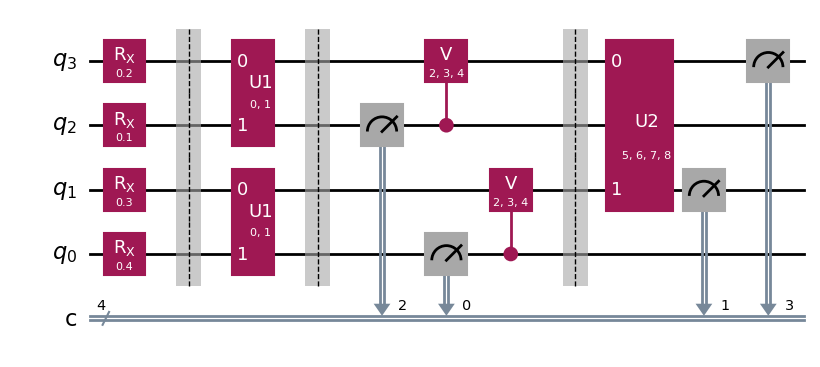

In [285]:
# Circuit 1
circ1 = circuit1(_features)
circ1.draw("mpl", reverse_bits=True)

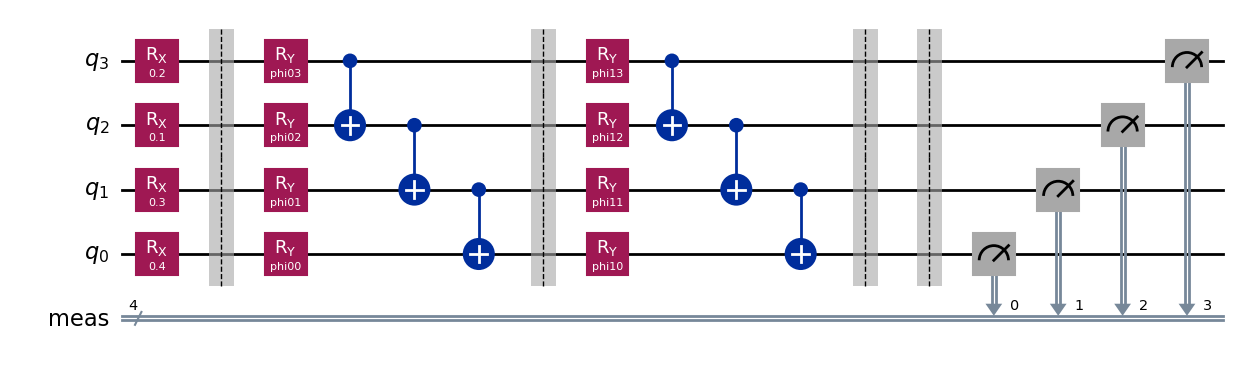

In [286]:
# Circuit 2
circ2 = circuit2(_features, layers=2)
circ2.draw("mpl", reverse_bits=True)

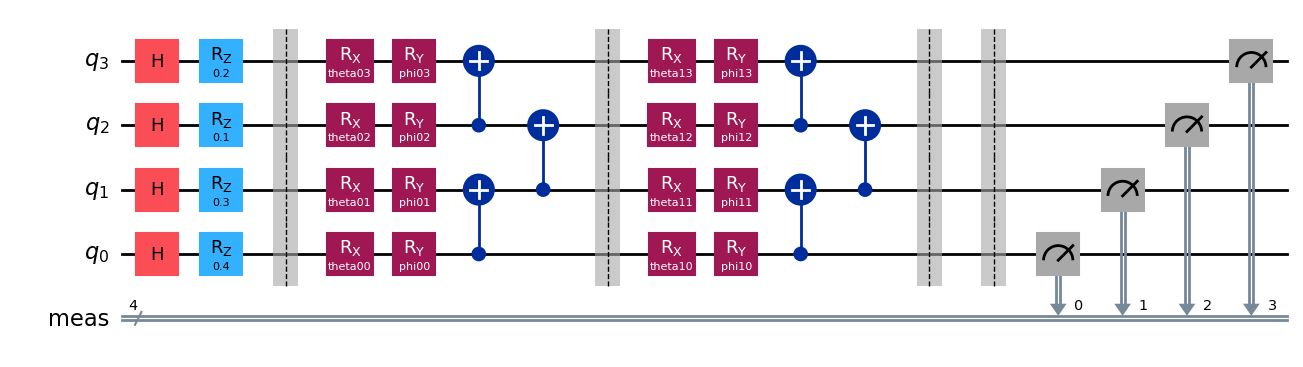

In [287]:
# Circuit 3
circ3 = circuit3(_features, layers=2)
circ3.draw("mpl", reverse_bits=True)

## Training and Validation

In [312]:
models = []
model_accuracies = []
n_samples = 5
lr_range = [1, 1.5] 
epsilon_range = [0.5, 1]
layers = [2, 3]
architectures = [Model1]#, Model2, Model3]

"""
Model2: lr:1.97, eps: 0.642, layers:4 
"""

epochs = 20
for architecture in architectures:
    for i in range(n_samples):
        model_parameters = {
            "learning_rate": round(np.random.uniform(*lr_range), 3),
            "epsilon": round(np.random.uniform(*epsilon_range),3),
            "layers": np.random.randint(*layers)
        }
        print(f"Model architecture: {architecture}")
        [print(f"{k}: {v}, ", end="") for k,v in model_parameters.items()]
        print()
        model = architecture(gradient_shots=1000, seed=SEED, **model_parameters)
        model = model.fit(epochs, X_train, y_train, X_val, y_val)
        pred_train = model.predict(X_train)
        pred_val = model.predict(X_val)
        train_acc = f1_score(y_train, pred_train, average="weighted")
        val_acc = f1_score(y_val, pred_val, average="weighted")
        print(f"Training accuracy: {train_acc*100:.2f}%, Validation accuracy: {val_acc*100:.2f}%")
        
        models.append(model)
        model_accuracies.append(val_acc)

Model architecture: <class 'src.Model1'>
learning_rate: 1.165, epsilon: 0.97, layers: 2, 
Epoch 1 Train loss: 0.9438926500036002 Validation loss: 0.9688433430488174
Epoch 2 Train loss: 0.902834419935123 Validation loss: 0.9346541611875007
Epoch 3 Train loss: 0.8779001191873501 Validation loss: 0.9113136093366737
Epoch 4 Train loss: 0.8548243420859094 Validation loss: 0.882378101449516
Epoch 5 Train loss: 0.8397204351513504 Validation loss: 0.8682572792058489
Epoch 6 Train loss: 0.8246249138007778 Validation loss: 0.8428214806032323
Epoch 7 Train loss: 0.8149577921908504 Validation loss: 0.8456930414534368
Epoch 8 Train loss: 0.7988534657143872 Validation loss: 0.8297192369417428
Epoch 9 Train loss: 0.7944468263468183 Validation loss: 0.84705510814679
Worse! Patience is increased to 1
Early stopping triggered.
Training accuracy: 72.63%, Validation accuracy: 58.44%
Model architecture: <class 'src.Model1'>
learning_rate: 1.083, epsilon: 0.775, layers: 2, 
Epoch 1 Train loss: 1.01292832378

In [ ]:
selected_model = models[model_accuracies.index(max(model_accuracies))]
#selected_model = models[3]

In [343]:
def plot_loss(train_loss, val_loss):
    plt.title("Training and Validation loss")
    plt.plot(train_loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.legend()
    plt.show()

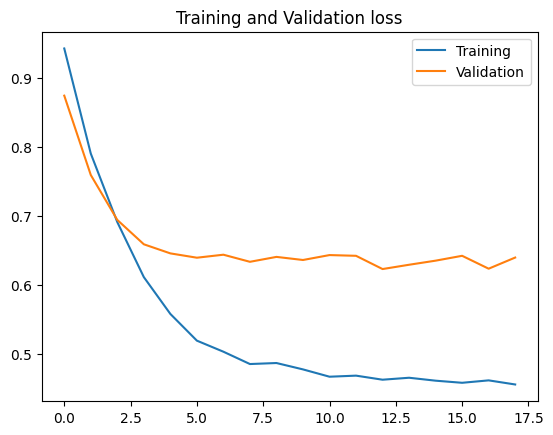

In [344]:
plot_loss(selected_model.train_loss, selected_model.val_loss)

## Test Performance

In [345]:
preds = selected_model.predict(X_test)
test_accuracy = f1_score(y_test, preds, average="weighted")

In [346]:
print(f"Test accuracy: {test_accuracy*100:.2f}%")
print(f"Model : {type(selected_model)}, epsilon : {selected_model.epsilon}, learning rate: {selected_model.learning_rate}")
print(f" {selected_model.parameters}")

Test accuracy: 84.68%
Model : <class 'src.Model1'>, epsilon : 0.913, learning rate: 1.37
 [1.34434214 0.50606515 0.54497743 1.99971511 2.43876739 2.97821155
 0.07583018 1.50315145 3.03116505]


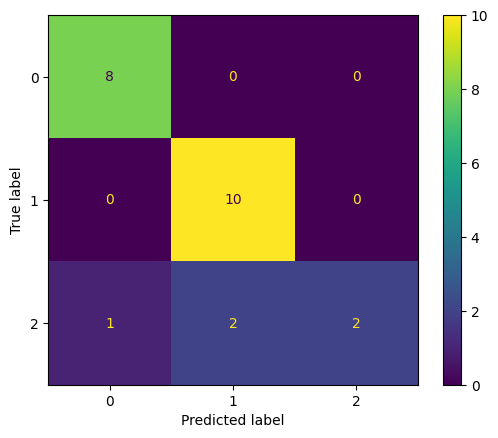

In [347]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()